In [1]:
import sys
print(sys.version)

3.5.4 |Anaconda custom (64-bit)| (default, Aug 14 2017, 13:26:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn import neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
pd.options.display.max_seq_items = 2000

# Functions

In [3]:
def get_X_and_Y(df):
    X = df.values[:, :-1]
    Y = df.values[:, -1:]
    return (X, Y)

In [5]:
def get_cv(clf, param_grid):
    return GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=8)

In [6]:
def get_values(l, param_name):
    return [d[param_name] for d in l]

In [100]:
def get_hyper_params(score):
    hyperparams = score['hyper-params'][0]
    params = hyperparams['params']
    param_name = list(params[0].keys())[0]
    param_range = get_values(params, param_name)
    train_scores = hyperparams['mean_train_score']
    test_scores = hyperparams['mean_test_score']
    return (param_name, param_range, train_scores, test_scores)

def plot_clf():
    fig = plt.figure(figsize=(18,6))
    for i, clf in enumerate(clf_names):
         for df, color in zip(df_names, colors):
            scale = 'linear'
            if clf == 'Logistic Regression':
                scale = 'log'
            score = results[results.index.str.contains(df + '_' + clf + '_0.2')]
            param_name, param_range, train_scores, test_scores = get_hyper_params(score)
            ax = fig.add_subplot(1, len(clf_names), i + 1)
            ax.plot(param_range, train_scores, color = color, label=df + " Training Score", linestyle = '--')
            ax.plot(param_range, test_scores, color = color, label=df + " Validation Score")
            ax.set_xlabel(param_name)
            ax.set_xscale(scale)
            ax.set_title(clf + " Cross-Validation scores")
    
    plt.legend(loc="best")
    plt.show()

In [59]:
def plot_accuracy(metric):
    fig = plt.figure(figsize=(18,6))
    for i, df in enumerate(df_names):
        for clf, color in zip(clf_names, colors):
            y_val = results[results.index.str.contains(df + '_' + clf)][metric].values
            ax = fig.add_subplot(1, len(df_names), i + 1)
            ax.plot(np.array(splits), y_val, color = color, label=clf, marker ='o')
            ax.set_title(df + " " + metric)

    plt.legend(loc="best")
    plt.show()

# Get the Data!

Import data from UCI Repository 

In [10]:
files = ['adult.data', 'letter-recognition.data', 'covtype.data'] 
df_adult, df_letter, df_covtype = [pd.read_csv(file, header=None) for file in files]

# Preprocess the Data!

## Inspect the ADULT dataset

In [11]:
# Based on the Data Description in 
# https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

df_adult.columns = ['age'
                    , 'workclass'
                    , 'fnlwgt'
                    , 'education'
                    , 'education-num'
                    , 'marital-status'
                    , 'occupation'
                    , 'relationship'
                    , 'race'
                    , 'sex'
                    , 'capital-gain'
                    , 'captial-loss'
                    , 'hours-per-week'
                    , 'native-country'
                    , 'income']

In [12]:
df_adult.isnull().values.any()

False

In [13]:
print('Number of rows in ADULT:' + str(len(df_adult)))

df_adult.head()

Number of rows in ADULT:32561


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Vectorize categorical columns in ADULT dataset

In [14]:
df_adult = pd.get_dummies(df_adult)

In [15]:
df_adult = df_adult.drop(['sex_ Female', 'income_ <=50K'], axis=1)

In [16]:
df_adult.head()

,age,fnlwgt,education-num,capital-gain,captial-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
len(df_adult[df_adult['income_ >50K'] == 1])

7841

### Convert to numpy arrays and split

In [18]:
df_adult = df_adult.sample(frac=1)
adult_X, adult_Y = get_X_and_Y(df_adult)

adult_X_train, adult_X_test, adult_Y_train, adult_Y_test = \
 train_test_split(adult_X, adult_Y, test_size=0.33)

In [19]:
# Don't split. rerun classifiers, randomizing train/test split each time. 

print('adult_X_train.shape: ' + str(adult_X_train.shape))
print('adult_Y_train.shape: ' + str(adult_Y_train.shape))
print('adult_X_test.shape : ' + str(adult_X_test.shape))
print('adult_Y_test.shape : ' + str(adult_Y_test.shape))


adult_X_train.shape: (21815, 107)
adult_Y_train.shape: (21815, 1)
adult_X_test.shape : (10746, 107)
adult_Y_test.shape : (10746, 1)


## Inspect the LETTER dataset

In [20]:
print('Number of rows in LETTER: ' + str(len(df_letter)))

df_letter.head()

Number of rows in LETTER: 20000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [21]:
# Based on the Data Description in 
# https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.names

df_letter.columns = [   'lettr'
                        , 'x-box'
                        , 'y-box'
                        , 'width'
                        , 'high '
                        , 'onpix'
                        , 'x-bar'
                        , 'y-bar'
                        , 'x2bar'
                        , 'y2bar'
                        , 'xybar'
                        , 'x2ybr'
                        , 'xy2br'
                        , 'x-ege'
                        , 'xegvy'
                        , 'y-ege'
                        , 'yegvx']

In [22]:
# In Caruana & Niculescu-Mizil,. 2006, 
# the LETTER.p2 dataset was analyzed with the first half of the alphabet
# being the positive case and all else negative. 
c2i = dict((chr(c), 1) for c in range(65,78))
df_letter['lettr'] = df_letter['lettr'].map(c2i).fillna(0)

In [23]:
df_letter.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,0.0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,1.0,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,1.0,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,0.0,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,1.0,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [24]:
# Make the 'lettr' column last to conform with other datasets. 
cols = df_letter.columns.tolist()
cols = cols[1:-2] + cols[:1]

In [25]:
df_letter = df_letter[cols]

In [26]:
len(df_letter[df_letter['lettr'] == 1])

9940

### Convert to numpy array and split

In [27]:
letter_X, letter_Y = get_X_and_Y(df_letter)

letter_X_train, letter_X_test, letter_Y_train, letter_Y_test = \
 train_test_split(letter_X, letter_Y, test_size=0.33)

In [28]:
print('letter_X_train.shape: ' + str(letter_X_train.shape))
print('letter_Y_train.shape: ' + str(letter_Y_train.shape))
print('letter_X_test.shape : ' + str(letter_X_test.shape))
print('letter_Y_test.shape : ' + str(letter_Y_test.shape))

letter_X_train.shape: (13400, 14)
letter_Y_train.shape: (13400, 1)
letter_X_test.shape : (6600, 14)
letter_Y_test.shape : (6600, 1)


## Inspect the COV_TYPE dataset

In [29]:
df_covtype.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [30]:
# Not going to rename columns here, there's way too many.
# According to https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info
# column 54 is the cover type, which is what we're classifying. 

In [31]:
# In Caruana & Niculescu-Mizil,. 2006, the COV_TYPE dataset 
# was classified with the largest covertype as the positive case, 
# all else negative

df_covtype[54] = df_covtype[54].map({2:1}).fillna(0)

In [32]:
len(df_covtype[df_covtype[54] == 1])

283301

In [33]:
df_covtype = df_covtype.head(20000)

## Combine Datasets

In [34]:
dfs = [df_adult, df_letter, df_covtype]

# Classifiers!

## Logistic Regression

In [35]:
param_grid = {'C': [10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 1, 10e1, 10e2, 10e3, 10e4]}
#param_grid = {'C': [10e-8, 10e-4, 1, 10e1]}
lr = get_cv(LogisticRegression(), param_grid)

## K Nearest Neighbors (KNN)

In [36]:
# In Caruana & Niculescu-Mizil,. 2006, there are 26 values of K
# ranging from 1 to |trainset|. Because 3200 is the smallest possible trainset
# we can achieve, we'll use that |trainset|. 

param_grid = {'n_neighbors': list(range(1, 3200, round(3200/26)))}
#param_grid = {'n_neighbors': list(range(1, 3))}
knn = get_cv(neighbors.KNeighborsClassifier(), param_grid)

## Random Forest (RF)

In [37]:
param_grid = {'n_estimators': list(range(100,1000,100))}
rf = get_cv(RandomForestClassifier(), param_grid)

## Combine Classifiers

In [38]:
clfs = [lr, knn, rf]

# Do the thing! 

## Constants

In [40]:
n_trials = 3
clf_names = ["Logistic Regression", "KNN", "Random Forest"]
df_names = ["ADULT", "LETTER", "COV_TYPE"]
splits = [.2, .5, .8]
colors = ['darkorange', 'navy', 'green']

df_space = tuple(zip(df_names, dfs))
clfs_space = tuple(zip(clf_names, clfs))

search_space_elements = [df_space, clfs_space, splits]

In [41]:
results = pd.DataFrame(columns = ['train_score', 'test_score', 'hyper-params'])
for df, clf, split in itertools.product(*search_space_elements):
    training_scores = []
    testing_scores = []
    key = df[0] + '_' + clf[0] + '_' + str(split)
    print(key)
    for i in range(n_trials): 
        data = df[1].sample(frac=1) # Shuffle the data.
        X, Y = get_X_and_Y(data)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split)
        clf[1].fit(X_train, Y_train.reshape(-1, ))
        train_score = max(clf[1].cv_results_['mean_train_score'])
        pred = clf[1].predict(X_test)
        training_scores.append(train_score)
        testing_scores.append(accuracy_score(Y_test, pred))
    results.loc[key] = [np.array(training_scores).mean(), np.array(testing_scores).mean(), clf[1].cv_results_]
print(results)


ADULT_Logistic Regression_0.2
ADULT_Logistic Regression_0.5
ADULT_Logistic Regression_0.8
ADULT_KNN_0.2
ADULT_KNN_0.5
ADULT_KNN_0.8
ADULT_Random Forest_0.2
ADULT_Random Forest_0.5
ADULT_Random Forest_0.8
LETTER_Logistic Regression_0.2
LETTER_Logistic Regression_0.5
LETTER_Logistic Regression_0.8
LETTER_KNN_0.2
LETTER_KNN_0.5
LETTER_KNN_0.8
LETTER_Random Forest_0.2
LETTER_Random Forest_0.5
LETTER_Random Forest_0.8
COV_TYPE_Logistic Regression_0.2
COV_TYPE_Logistic Regression_0.5
COV_TYPE_Logistic Regression_0.8
COV_TYPE_KNN_0.2
COV_TYPE_KNN_0.5
COV_TYPE_KNN_0.8
COV_TYPE_Random Forest_0.2
COV_TYPE_Random Forest_0.5
COV_TYPE_Random Forest_0.8
                                  train_score  test_score  \
ADULT_Logistic Regression_0.2        0.796453    0.801167   
ADULT_Logistic Regression_0.5        0.798587    0.797003   
ADULT_Logistic Regression_0.8        0.792537    0.798380   
ADULT_KNN_0.2                        1.000000    0.783971   
ADULT_KNN_0.5                        1.000000  

# Graph the Results!

In [42]:
results.to_csv('results.csv')

In [59]:
def plot_accuracy(metric):
    fig = plt.figure(figsize=(18,6))
    for i, df in enumerate(df_names):
        for clf, color in zip(clf_names, colors):
            y_val = results[results.index.str.contains(df + '_' + clf)][metric].values
            ax = fig.add_subplot(1, len(df_names), i + 1)
            ax.plot(np.array(splits), y_val, color = color, label=clf, marker ='o')
            ax.set_title(df + " " + metric)

    plt.legend(loc="best")
    plt.show()

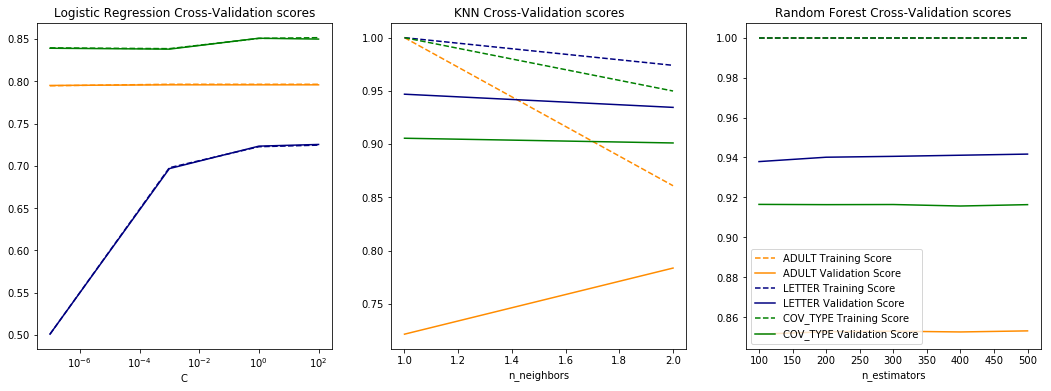

In [102]:
plot_clf()

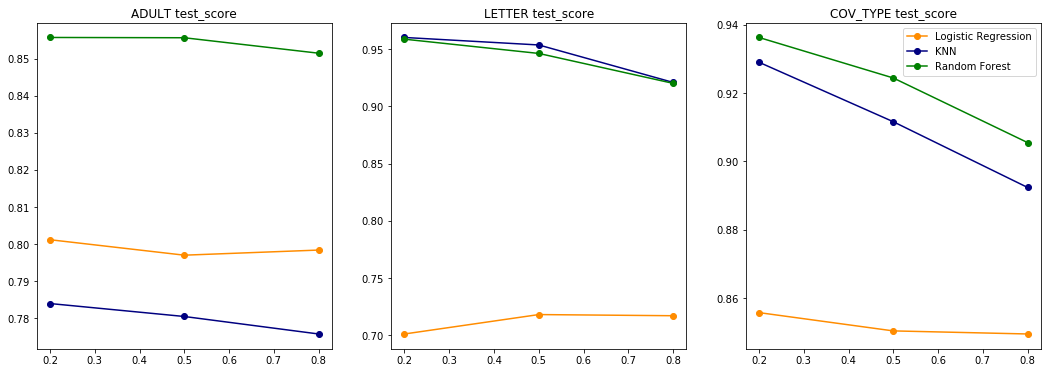

In [60]:
plot_accuracy("test_score")

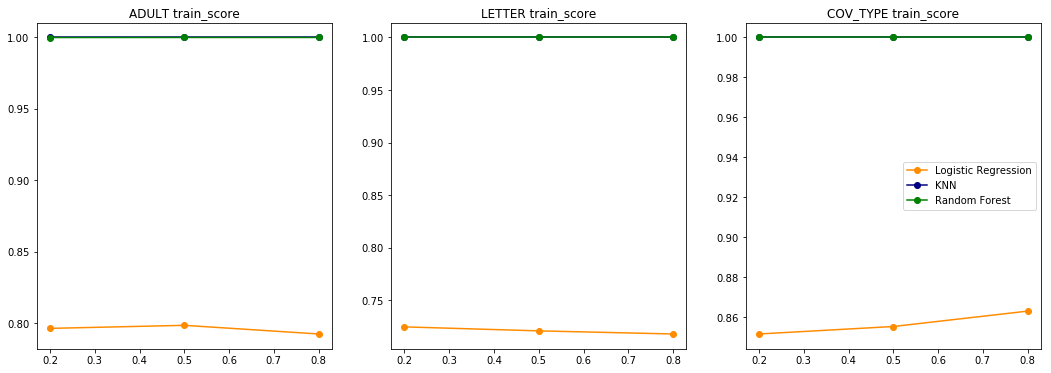

In [103]:
plot_accuracy("train_score")

# Scratch CODEEE!

In [ ]:
for df, clf in itertools.product(*[df_names, clf_names]):
    print(results[results.index.str.contains(df + '_' + clf)]['train_score'])

In [ ]:
len(df_covtype[df_covtype[54] == 1])

In [ ]:
x, y = get_X_and_Y(df_covtype)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.99)

print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

clf = neighbors.KNeighborsClassifier(2)
#clf = RandomForestClassifier()
clf.fit(X_train, Y_train.reshape(-1,))
pred = clf.predict(X_test)
print(accuracy_score(Y_test, pred))

## Logistic Regression

In [ ]:
param_grid = {'C': [10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1, 10e1, 10e2, 10e3, 10e4]}
#param_grid = {'C': [10e-8, 10e4]}
clf = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
clf


## ADULT Dataset

In [ ]:
run_clf(clf, adult_X_train, adult_Y_train, adult_X_test, adult_Y_test)

In [ ]:
clf.cv_results_
#[d['value'] for d in l]
p = clf.cv_results_['params']
print([list(d.values())[0] for d in p])
plt.semilogx([list(d.values())[0] for d in p], clf.cv_results_['mean_train_score'], 'g', label='train')
plt.semilogx([list(d.values())[0] for d in p], clf.cv_results_['mean_test_score'], 'r', label='test')
plt.legend(loc = 'upper right')
plt.show()

### LETTER Dataset

In [ ]:
run_clf(clf, letter_X_train, letter_Y_train, letter_X_test, letter_Y_test)

### COV_TYPE Dataset

In [ ]:
run_clf(clf, covtype_X_train, covtype_Y_train, covtype_X_test, covtype_Y_test)

In [ ]:
#clf.fit(covtype_X_train, covtype_Y_train.reshape(-1, ))

In [ ]:
#results(clf, covtype_X_test, covtype_Y_test, "COV_TYPE")

## KNN

In [ ]:
k = np.arange(5) + 1
parameters = {'n_neighbors': k}
knn = neighbors.KNeighborsClassifier()
knn = GridSearchCV(knn,parameters,cv=5)
#clf = neighbors.KNeighborsClassifier(3)

### Adult

In [ ]:
run_clf(knn, adult_X_train, adult_Y_train, adult_X_test, adult_Y_test)

In [ ]:
knn.cv_results_['mean_train_score']

In [ ]:
knn.cv_results_
#[d['value'] for d in l]
p = knn.cv_results_['params']
print([list(d.values())[0] for d in p])
plt.plot([list(d.values())[0] for d in p], knn.cv_results_['mean_train_score'], 'g', label='train')
plt.plot([list(d.values())[0] for d in p], knn.cv_results_['mean_test_score'], 'r', label='test')
plt.legend(loc = 'upper right')
plt.show()

### LETTER

In [ ]:
run_clf(clf, letter_X_train, letter_Y_train, letter_X_test, letter_Y_test)

### COV_TYPE

In [ ]:
run_clf(clf, covtype_X_train, covtype_Y_train, covtype_X_test, covtype_Y_test)

## Random Forest

In [ ]:
clf = RandomForestClassifier()

### ADULT

In [ ]:
run_RF(clf, adult_X_train, adult_Y_train, adult_X_test, adult_Y_test)

### LETTER

In [ ]:
run_RF(clf, letter_X_train, letter_Y_train, letter_X_test, letter_Y_test)

### COV_TYPE

In [ ]:
run_RF(clf, covtype_X_train, covtype_Y_train, covtype_X_test, covtype_Y_test)